In [2]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
sys.path.insert(0, '../src')

from utils import *

In [4]:
sns.set(rc={'figure.figsize':(20,5)})

In [5]:
low_fp = '../data/240p/' 
med_fp = '../data/480p/'
high_fp = '../data/1080p/' 

In [6]:
mbit_rate = 1/125000

In [ ]:
## loading in multiple data sets; primarily to compare and contrast the difference betweena action and still later on
iman_low = pd.read_csv(low_fp + 'imnemato-104-action-240p-20210110.csv')
iman_med = pd.read_csv(med_fp + 'imnemato-104-action-480p-20210110.csv')
iman_high = pd.read_csv(high_fp + 'imnemato-104-action-1080p-20210110.csv')

imm_low = filter_ip(iman_low)
imm_med = filter_ip(iman_med)
imm_high = filter_ip(iman_high)

andrew_low = pd.read_csv(low_fp+'sgs008-107-still-240p-20210112.csv')
andrew_med = pd.read_csv(med_fp+'sgs008-107-still-480p-20210112.csv')
andrew_high = pd.read_csv(high_fp+'sgs008-107-still-1080p-20210112.csv')

sgs_low = filter_ip(andrew_low)
sgs_med = filter_ip(andrew_med)
sgs_high = filter_ip(andrew_high)

shrimant_low = pd.read_csv(low_fp + 'shs214-108-action-240p-20210112.csv')
shrimant_med = pd.read_csv(med_fp + 'shs214-108-action-480p-20210112.csv')
shrimant_high = pd.read_csv(high_fp + 'shs214-108-action-1080p-20210112.csv')

# shrimant_low = pd.read_csv(low_fp + 'shs214-103-still-240p-20210109.csv')
# shrimant_med = pd.read_csv(med_fp + 'shs214-103-still-480p-20210109.csv')
# shrimant_high = pd.read_csv(high_fp + 'shs214-103-still-1080p-20210109.csv')

shs_low = filter_ip(shrimant_low)
shs_med = filter_ip(shrimant_med)
shs_high = filter_ip(shrimant_high)

In [6]:
stdoan_low = pd.read_csv(low_fp + 'stdoan-101-action-240p-20201127.csv')
stdoan_med = pd.read_csv(med_fp + 'stdoan-101-action-480p-20201127.csv')
stdoan_high = pd.read_csv(high_fp + 'stdoan-101-action-1080p-20201127.csv')

## Quick Summary Statistics

Ran the summary function on the 3 different resolutions just to get a brief overview of what we're working with. The main difference we see is that the averages of the download and upload bytes increases as the resolution increase. However, it doesn't seem to be an exactly "linear" increase. The number of bytes and packets seem to increase almost exponentially as the resolution increases. 

In [ ]:
stdoan_low[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe()

In [ ]:
stdoan_med[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe()

In [ ]:
stdoan_high[['2->1Bytes', '1->2Bytes', '2->1Pkts', '1->2Pkts']].describe()

## Comparing Byte Stream

I plotted the download and upload stream of bytes from 3 resolutions onto one graph. Though I initially plotted these seperately, by comparing all resolutions on the same scale, I can start to see how much difference there is in behavior. From initial observations, I can see that higher resolutions typically send more data more frequently. However, the download stream of lower resolutions seems to be fairly nonperiodic. This can be a problem later on when we try to apply something like FFT or Welch's method. 

Upload has the same frequency of data but on a small scale of download. 

(-2, 120)

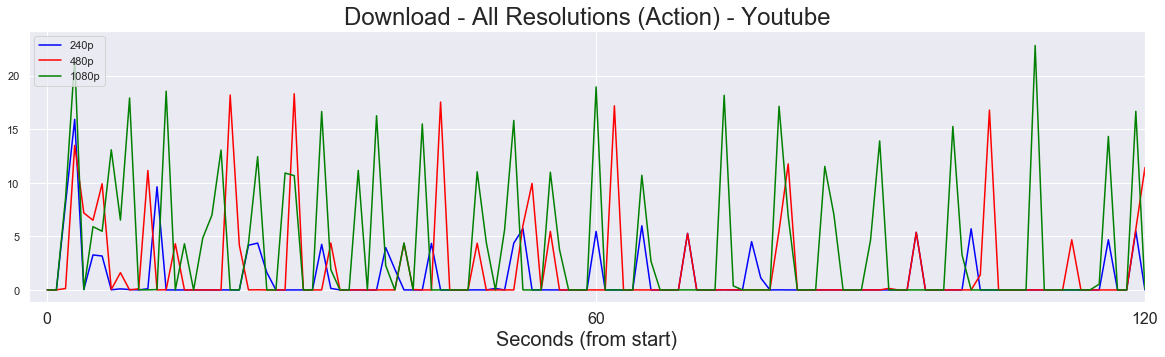

In [7]:
low_grp = stdoan_low.groupby('Time')['2->1Bytes'].sum()
med_grp = stdoan_med.groupby('Time')['2->1Bytes'].sum()
high_grp = stdoan_high.groupby('Time')['2->1Bytes'].sum()

plt.plot(low_grp.values * mbit_rate, label='240p', color='blue')
plt.plot(med_grp.values * mbit_rate, label='480p', color='red')
plt.plot(high_grp.values * mbit_rate, label='1080p', color='green')

plt.legend(loc='upper left')

plt.title('Download - All Resolutions (Action) - Youtube', fontsize=24)

plt.xlabel('Seconds (from start)', fontsize=20)
plt.xticks([0, 60, 120, 180, 240], fontsize=16)
plt.xlim(-2, 120)

(-2, 120)

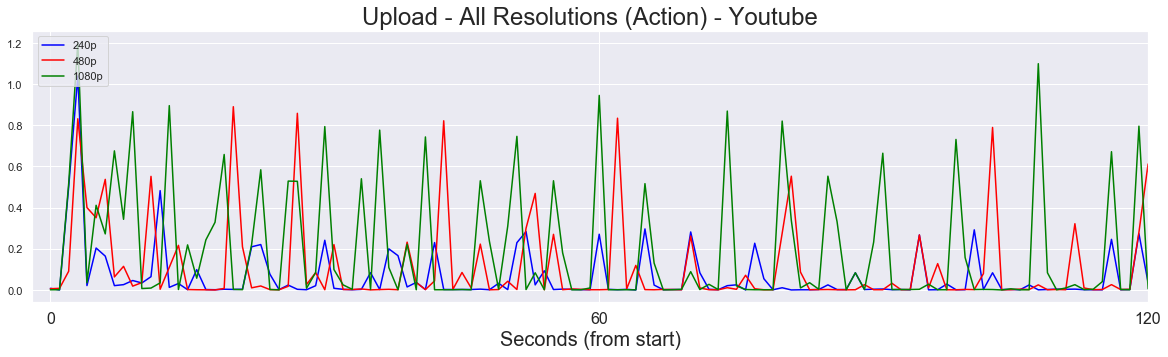

In [8]:
low_grp = stdoan_low.groupby('Time')['1->2Bytes'].sum()
med_grp = stdoan_med.groupby('Time')['1->2Bytes'].sum()
high_grp = stdoan_high.groupby('Time')['1->2Bytes'].sum()

plt.plot(low_grp.values * mbit_rate, label='240p', color='blue')
plt.plot(med_grp.values * mbit_rate, label='480p', color='red')
plt.plot(high_grp.values * mbit_rate, label='1080p', color='green')

plt.legend(loc='upper left')

plt.title('Upload - All Resolutions (Action) - Youtube', fontsize=24)

plt.xlabel('Seconds (from start)', fontsize=20)
plt.xticks([0, 60, 120, 180, 240], fontsize=16)
plt.xlim(-2, 120)

## Quick Spectral Analysis

Basing off of last quarter, I used Welch's method to get a quick look at what was happening in the domain frequency.

Main take away is that the PSD varies greatly when comparing resolutions. When comparing the plots on its own respective scale, it looks as though there seems to be some shared similarities. However, when directly plotted on the same axis, we see that 1080p dwarfs the other two. This was hinted at the beginning when we were taking our summary stats.

So using the PSD values seems to be a good start for feature engineering. 

In [12]:
low_ms = convert_ms_df(stdoan_low, True)
med_ms = convert_ms_df(stdoan_med, True)
high_ms = convert_ms_df(stdoan_high, True)

low_resample = low_ms.resample('500ms', on='Time').sum()
med_resample = med_ms.resample('500ms', on='Time').sum()
high_resample = high_ms.resample('500ms', on='Time').sum()

f_low, Pxx_low = sp.signal.welch(low_resample['pkt_size'])
f_med, Pxx_med = sp.signal.welch(med_resample['pkt_size'])
f_high, Pxx_high = sp.signal.welch(high_resample['pkt_size'])

In [7]:
high_resample = high_ms.resample('250ms', on='Time').sum()
test_welch = high_resample[100:1300]

test_f, Pxx_f = sp.signal.welch(test_welch['pkt_size'], fs=4)

NameError: name 'high_ms' is not defined

In [8]:
iman_high = pd.read_csv(high_fp + 'imnemato-104-action-1080p-20210110.csv')

iman_ms = convert_ms_df(iman_high, True)
iman_resample = iman_ms.resample('1000ms', on='Time').sum()

In [101]:
f_iman, Pxx_iman = sp.signal.welch(iman_resample['pkt_size'], fs=4)

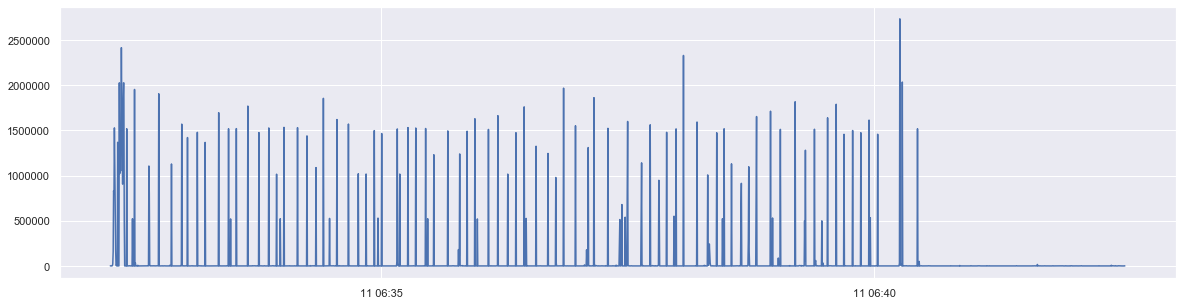

In [103]:
plt.plot(iman_resample)

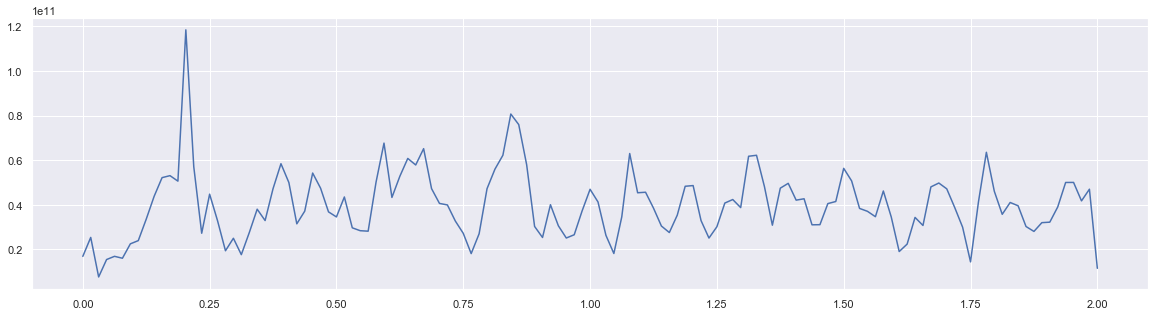

In [102]:
plt.plot(f_iman, Pxx_iman)

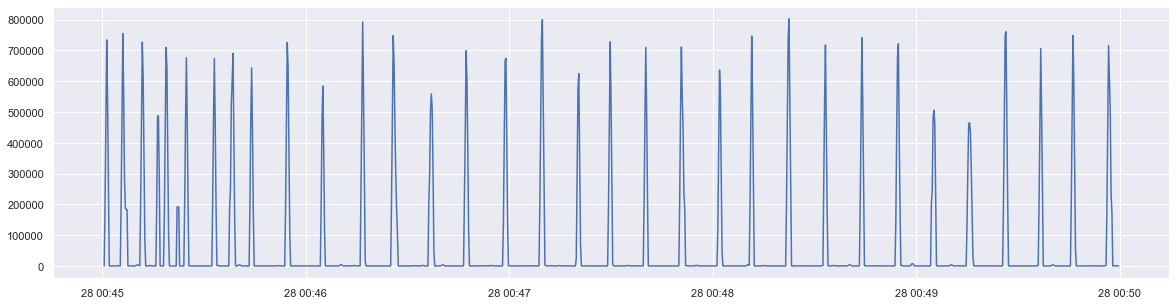

In [96]:
plt.plot(test_welch.rolling(3).mean()['pkt_size'])
                           

In [97]:
test_welch.head(10)

,pkt_size
Time,
2020-11-28 00:45:00.000,0
2020-11-28 00:45:00.250,0
2020-11-28 00:45:00.500,0
2020-11-28 00:45:00.750,575499
2020-11-28 00:45:01.000,811584
2020-11-28 00:45:01.250,815622
2020-11-28 00:45:01.500,1466
2020-11-28 00:45:01.750,0
2020-11-28 00:45:02.000,0


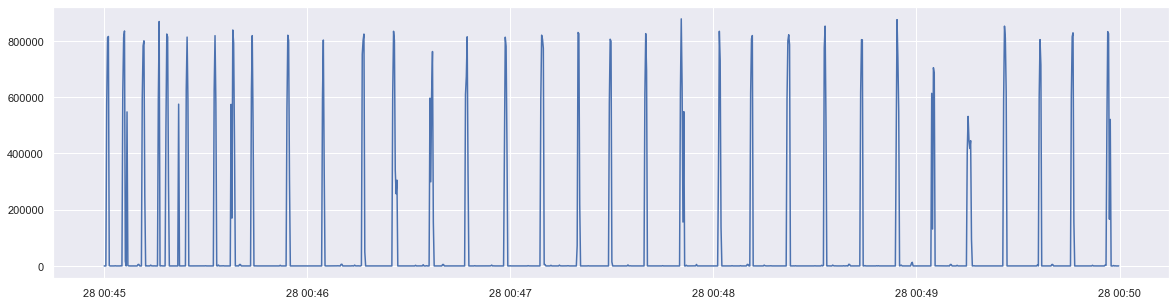

In [94]:
## time series
plt.plot(test_welch)

Text(0.5, 1.0, 'first 100 samples cut off')

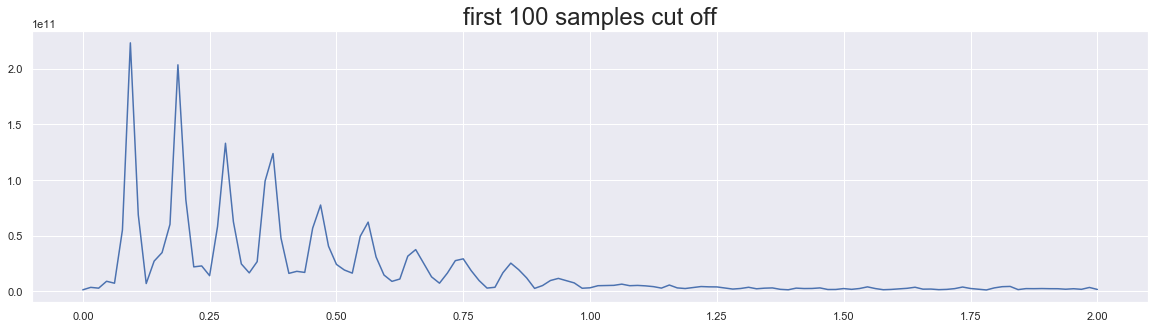

In [93]:
## first 100 samples cut off
plt.plot(test_f, Pxx_f)
plt.title('first 100 samples cut off', fontsize = 24)

Text(0.5, 0, 'Frequency')

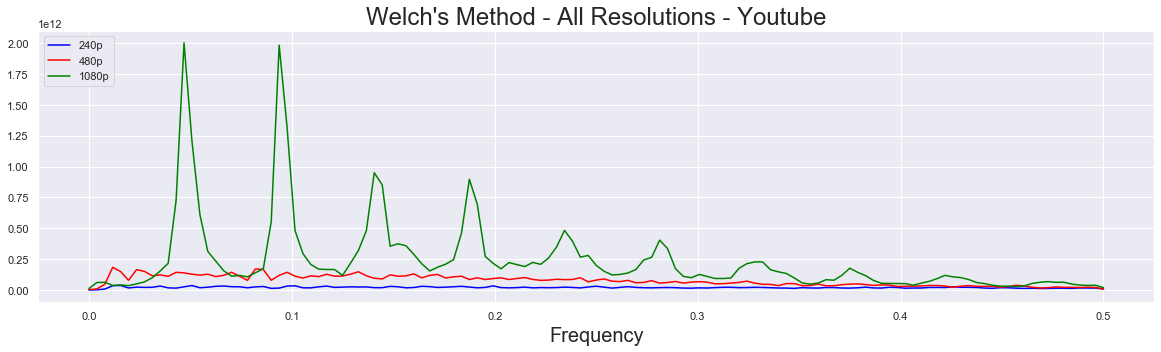

In [15]:
plt.plot(f_low, Pxx_low, label = '240p',  color='blue')
plt.plot(f_med, Pxx_med, label = '480p', color = 'red')
plt.plot(f_high, Pxx_high, label = '1080p', color ='green')

plt.legend(loc='upper left')

plt.title('Welch\'s Method - All Resolutions - Youtube', fontsize=24)

plt.xlabel('Frequency', fontsize=20)

Text(0.5, 0, 'Frequency')

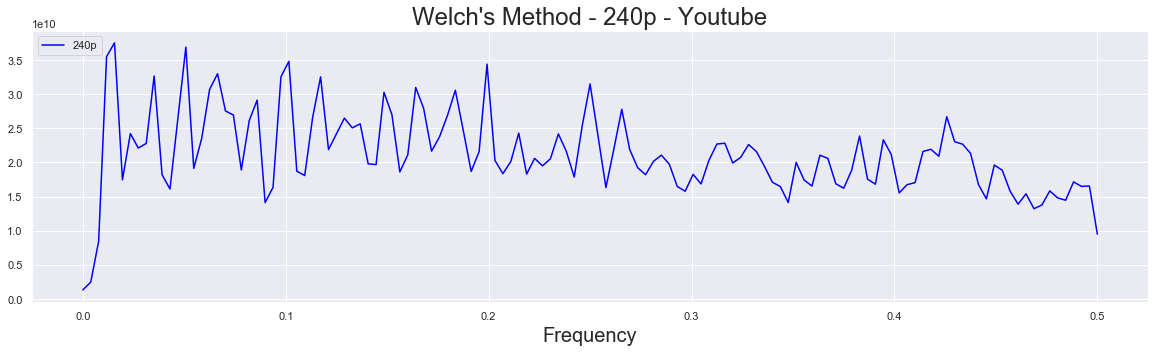

In [13]:
plt.plot(f_low, Pxx_low, label = '240p',  color='blue')

plt.legend(loc='upper left')

plt.title('Welch\'s Method - 240p - Youtube', fontsize=24)

plt.xlabel('Frequency', fontsize=20)

Text(0.5, 0, 'Frequency')

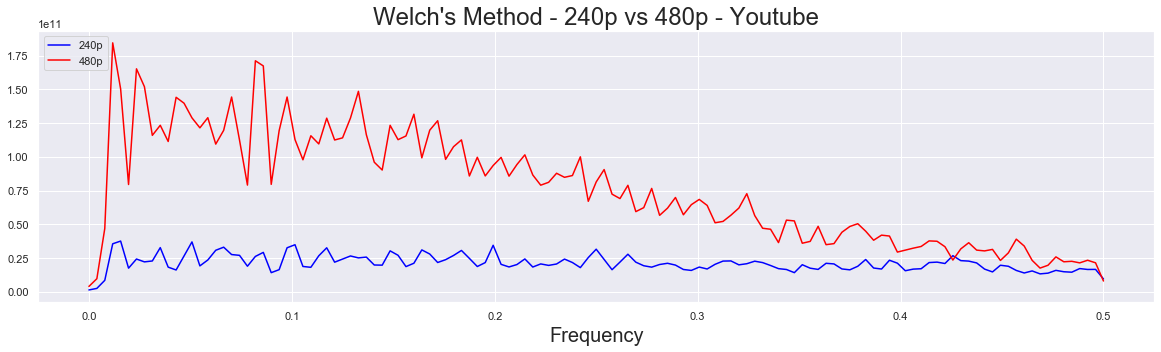

In [14]:
plt.plot(f_low, Pxx_low, label = '240p',  color='blue')
plt.plot(f_med, Pxx_med, label = '480p', color = 'red')

plt.legend(loc='upper left')

plt.title('Welch\'s Method - 240p vs 480p - Youtube', fontsize=24)

plt.xlabel('Frequency', fontsize=20)

## 2 Minutes

Text(0.5, 1.0, 'First 2 Minutes (Raw)')

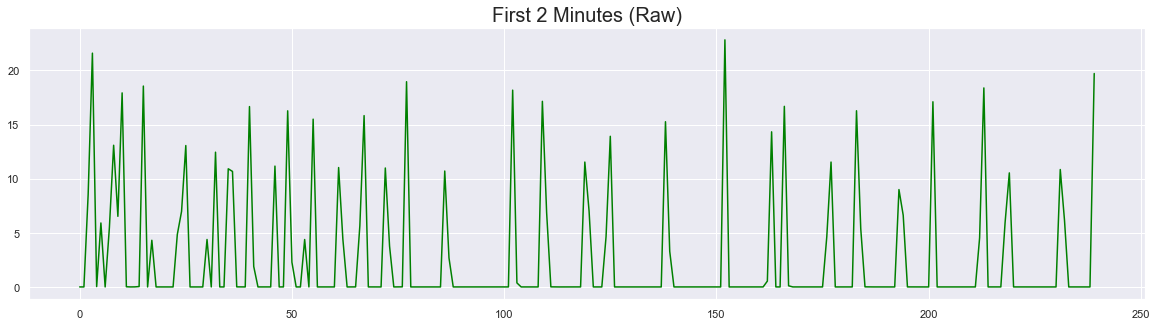

In [61]:
plt.plot(np.arange(240), stdoan_high['2->1Bytes'][0:240] * mbit_rate, label='1080p', color='green')
plt.title('First 2 Minutes (Raw)', fontsize=20)

Text(0.5, 1.0, 'First 2 Minutes (Resampled)')

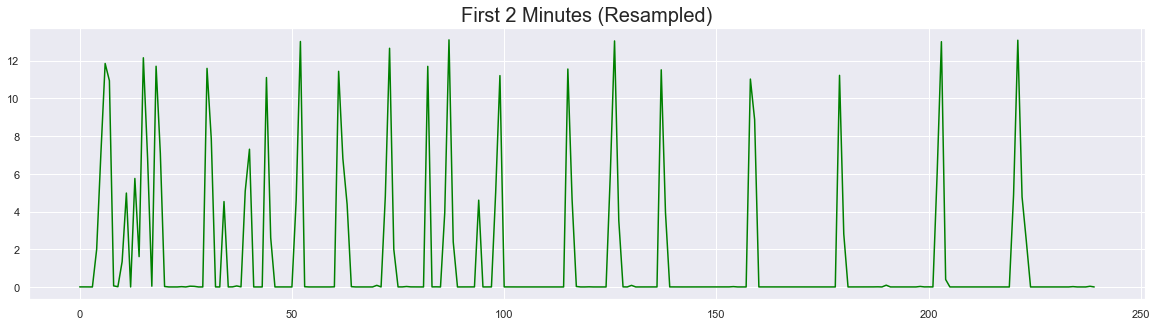

In [62]:
plt.plot(np.arange(240), high_resample[0:240] * mbit_rate, label='1080p', color='green')
plt.title('First 2 Minutes (Resampled)', fontsize=20)

## 5 Minutes

Text(0.5, 1.0, 'First 5 Minutes (Raw)')

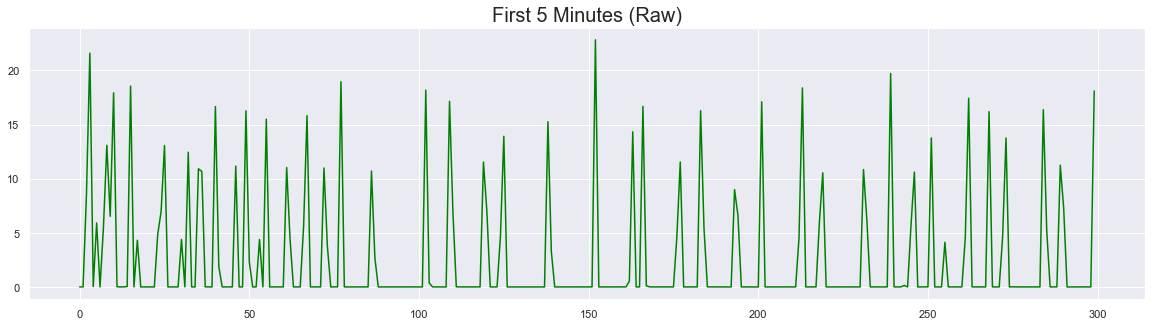

In [63]:
plt.plot(np.arange(300), stdoan_high['2->1Bytes'][0:300] * mbit_rate, label='1080p', color='green')
plt.title('First 5 Minutes (Raw)', fontsize=20)

Text(0.5, 1.0, 'First 5 Minutes (Resampled)')

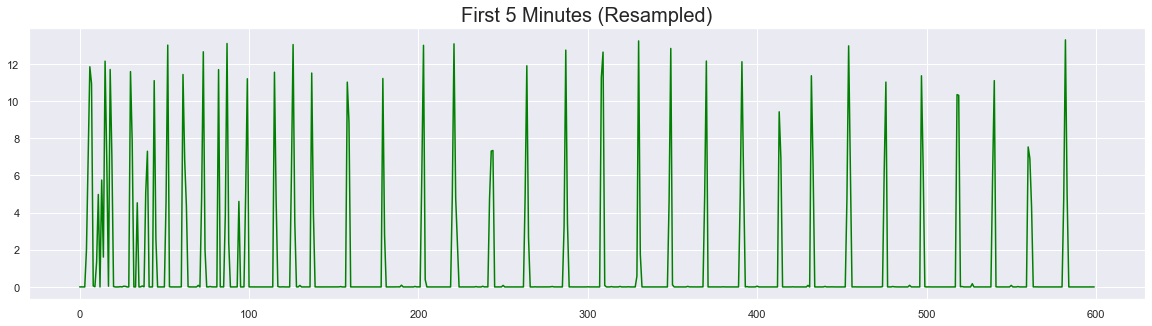

In [82]:
plt.plot(np.arange(600), high_resample[0:600] * mbit_rate, label='1080p', color='green')
plt.title('First 5 Minutes (Resampled)', fontsize=20)

## 10 Minutes

In [83]:
stdoan.

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
100,1606524374,192.168.1.173,59390,137.110.0.70,443,17,247,137,2,1,1606524374440;1606524374528;1606524374572;,141;137;106;,1;2;1;
101,1606524375,192.168.1.173,59390,137.110.0.70,443,17,254,276,2,2,1606524375044;1606524375048;1606524375069;1606...,127;127;138;138;,1;1;2;2;
102,1606524376,192.168.1.173,59390,137.110.0.70,443,17,108579,2271961,848,1690,1606524376248;1606524376248;1606524376248;1606...,126;1366;534;126;126;1346;1346;1346;126;1346;1...,1;1;1;2;2;2;2;2;1;2;2;2;1;1;2;2;1;2;2;1;2;2;1;...
103,1606524377,192.168.1.173,59390,137.110.0.70,443,17,2374,46778,19,36,1606524377000;1606524377000;1606524377000;1606...,1346;1346;1346;126;1346;126;1346;1346;1346;126...,2;2;2;1;2;1;2;2;2;1;2;2;1;2;2;1;2;2;2;1;1;2;2;...
104,1606524377,192.168.1.173,29611,137.110.0.70,443,6,117,117,2,2,1606524377042;1606524377063;1606524377065;1606...,77;40;77;40;,1;2;2;1;
105,1606524378,192.168.1.173,59390,137.110.0.70,443,17,254,276,2,2,1606524378484;1606524378508;1606524378958;1606...,127;138;127;138;,1;2;1;2;
106,1606524382,192.168.1.173,59390,137.110.0.70,443,17,127,138,1,1,1606524382823;1606524382850;,127;138;,1;2;
107,1606524383,192.168.1.173,59390,137.110.0.70,443,17,127,138,1,1,1606524383362;1606524383393;,127;138;,1;2;
108,1606524384,192.168.1.173,59390,137.110.0.70,443,17,127,138,1,1,1606524384447;1606524384478;,127;138;,1;2;
109,1606524385,192.168.1.173,59390,137.110.0.70,443,17,102520,2143084,800,1594,1606524385291;1606524385292;1606524385323;1606...,1366;534;126;126;1346;1346;1346;126;1346;1346;...,1;1;2;2;2;2;2;1;2;2;1;2;1;2;2;1;2;2;1;2;2;1;2;...


Text(0.5, 1.0, 'First 10 Minutes (Resampled)')

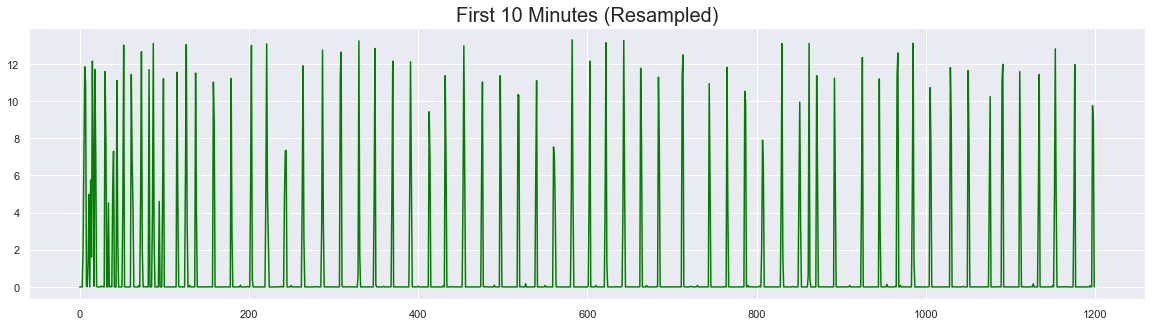

In [65]:
## .5s(500ms) between each x value

plt.plot(np.arange(1200), high_resample[0:1200] * mbit_rate, label='1080p', color='green')
plt.title('First 10 Minutes (Resampled)', fontsize=20)

## 20 Minutes

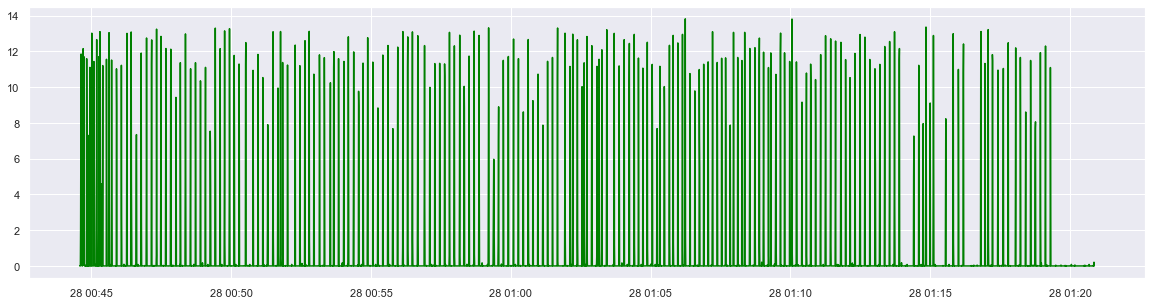

In [69]:
plt.plot(high_resample * mbit_rate, color='green')

In [ ]:
f, t, Sxx = sp.signal.spectrogram(low_resample['pkt_size'].values, 2)

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = sp.signal.spectrogram(med_resample['pkt_size'].values, fs = 2)

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = sp.signal.spectrogram(high_resample['pkt_size'].values, 2)

f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()